In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import pandas as pd
from tqdm import tqdm


## Test creating a complete biome_map from HCB_Results_Global.txt from https://github.com/jandepue/hydro-climatic-biomes

In [2]:
Class_names = {
	0: ['mid-latitude water-driven','0x965635','MidL_W'],
	1: ['transitional energy-driven','0xA5CC46','Trans_E'],
	2: ['boreal energy-driven','0x44087C','Bor_E'],
	3: ['tropical','0x4967D9','Tropic'],
	4: ['boreal temperature-driven','0xcc76d1','Bor_T'],
	6: ['subtropical water-driven','0xE8A76B','SubTr_E'],
	5: ['mid-latitude temperature-driven','0x4A885B','MidL_T'],
	7: ['boreal water/temperature-driven','0x5F3693','Bor_WT'],
	8: ['transitional water-driven','0xA6EB99','Trans_W'],
	9: ['boreal water-driven','0x8E71D5','Bor_W'],
	10:['subtropical energy-driven','0x296218','SubTr_E'],
    11: ['missing value', '0x808080', 'MISS'],
    12: ['missing value', '0x000000', 'MISS'],
}

In [3]:
data = np.loadtxt('HCB_Results_Global.txt')

In [4]:
df = pd.DataFrame(data, columns=['lat','lon','class'])
df['class_str'] = df['class'].apply(lambda x: Class_names[x][0])
df['color'] = df['class'].apply(lambda x: Class_names[x][1])

df['img_x'] = df['lon'].apply(lambda x: (int(x - data[:,1].min()) / (data[:,1].max() - data[:,1].min()))*359)
df['img_x'] = df['img_x'].astype(int)
df['img_y'] = df['lat'].apply(lambda x: (int(x - data[:,0].min()) / (data[:,0].max() - data[:,0].min()))*136 * -1)
df['img_y'] = df['img_y'].astype(int)

In [5]:
print(df.describe())


                lat           lon         class         img_x         img_y
count  13072.000000  13072.000000  13072.000000  13072.000000  13072.000000
mean      30.856870     20.518283      3.480034    199.944844    -85.356870
std       32.429858     88.377899      2.870963     88.409634     32.429858
min      -54.500000   -179.500000      0.000000      0.000000   -136.000000
25%        4.500000    -65.500000      1.000000    113.000000   -113.000000
50%       40.500000     32.500000      2.000000    212.000000    -95.000000
75%       58.500000     98.500000      6.000000    278.000000    -59.000000
max       81.500000    179.500000     10.000000    359.000000      0.000000


In [6]:
img_data = np.ones((137,360,4))

for x in range(img_data.shape[0]):
    for y in range(img_data.shape[1]):
        img_data[x,y,:] = matplotlib.colors.to_rgba('#' + Class_names[11][1][2:])


for i in range(len(df)):
    img_data[df['img_y'][i],df['img_x'][i],:] = matplotlib.colors.to_rgba('#' + df['color'][i][2:])


    

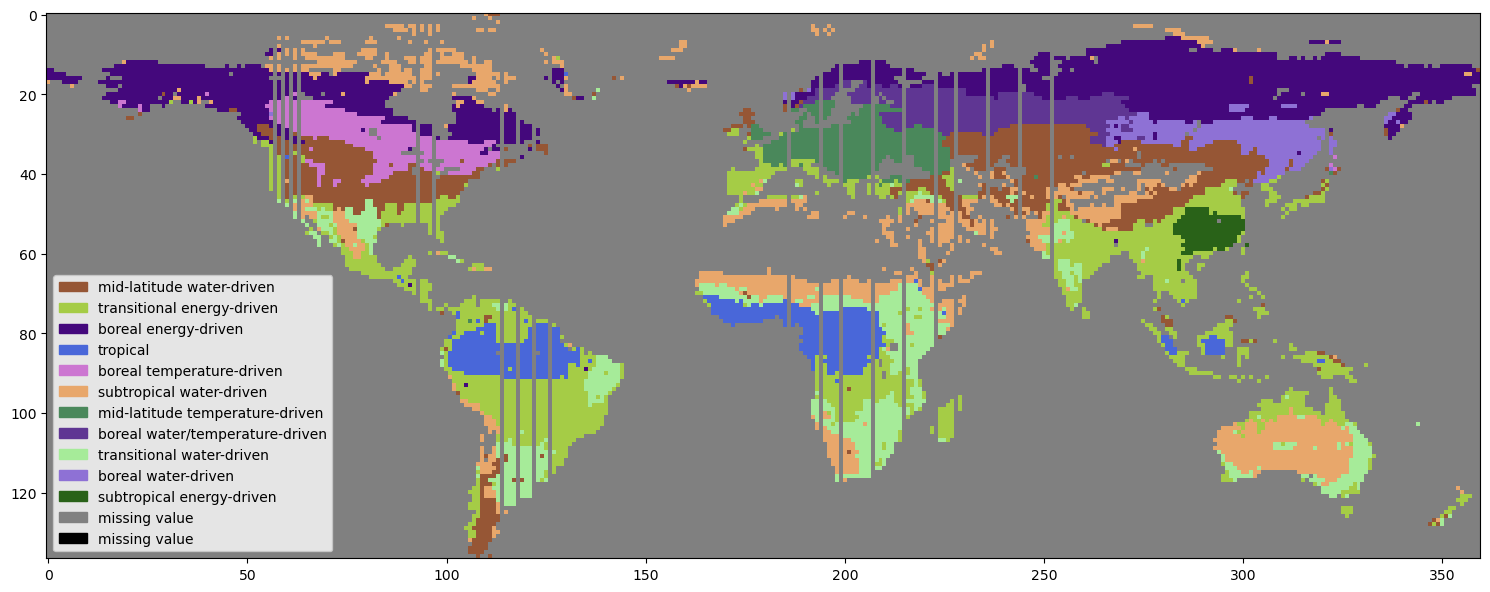

In [7]:
import matplotlib.patches as mpatches

def plot(plot_data):
        
    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 10.5)

    patches = []
    for data in Class_names.values():
        patches.append(mpatches.Patch(color='#' + data[1][2:], label=data[0]))
        # patches.append(mpatches.Patch(color=data[1], label=data[0]))
    ax.legend(handles=patches, loc='lower left')

    plt.imshow(plot_data)
    plt.show()


plot(img_data)

-> Sadly too much data missing, also the biomes are not the same as in [the paper](https://gmd.copernicus.org/articles/11/4139/2018/gmd-11-4139-2018.pdf)

-> Try to reconstruct the biomes using only the image from the paper

## Reconstruct from image:

In [8]:
from PIL import Image

image = Image.open('img_large_resized.png')
data = np.asarray(image)
print(data.shape)

scaling_factor = int(data.shape[1]/360)


reconstructed_data = np.zeros((180 * scaling_factor,data.shape[1],4))
reconstructed_data[:,:,:3] = 0.5
reconstructed_data[:,:,3] = 1.0

reconstructed_biomes = np.ones((180 * scaling_factor,data.shape[1],1))
reconstructed_biomes.fill(11)

for x in tqdm(range(data.shape[0])):
    for y in range(data.shape[1]):
        
        best_distance = 10e7
        best_color = -1

        position = (x + int(16.5 * scaling_factor), y)

        color = data[x,y,:3]

        for key, value in Class_names.items():
            comparison_color = matplotlib.colors.to_rgb('#' + value[1][2:])
            distance = np.mean((data[x,y,:3] /255 - comparison_color)**2)


            if distance < best_distance:
                best_distance = distance
                best_color = key
                    
        # if best_color is 'black' we also have a missing value
        if best_color == 12:
            best_color = 11

        reconstructed_data[position] = matplotlib.colors.to_rgba('#' + Class_names[best_color][1][2:])
        reconstructed_biomes[position] = best_color


reconstructed_biomes =  np.roll(reconstructed_biomes, int(reconstructed_data.shape[1]/2), axis=1)
reconstructed_data =  np.roll(reconstructed_data, int(reconstructed_data.shape[1]/2), axis=1)

(522, 1440, 4)


100%|██████████| 522/522 [00:52<00:00,  9.89it/s]


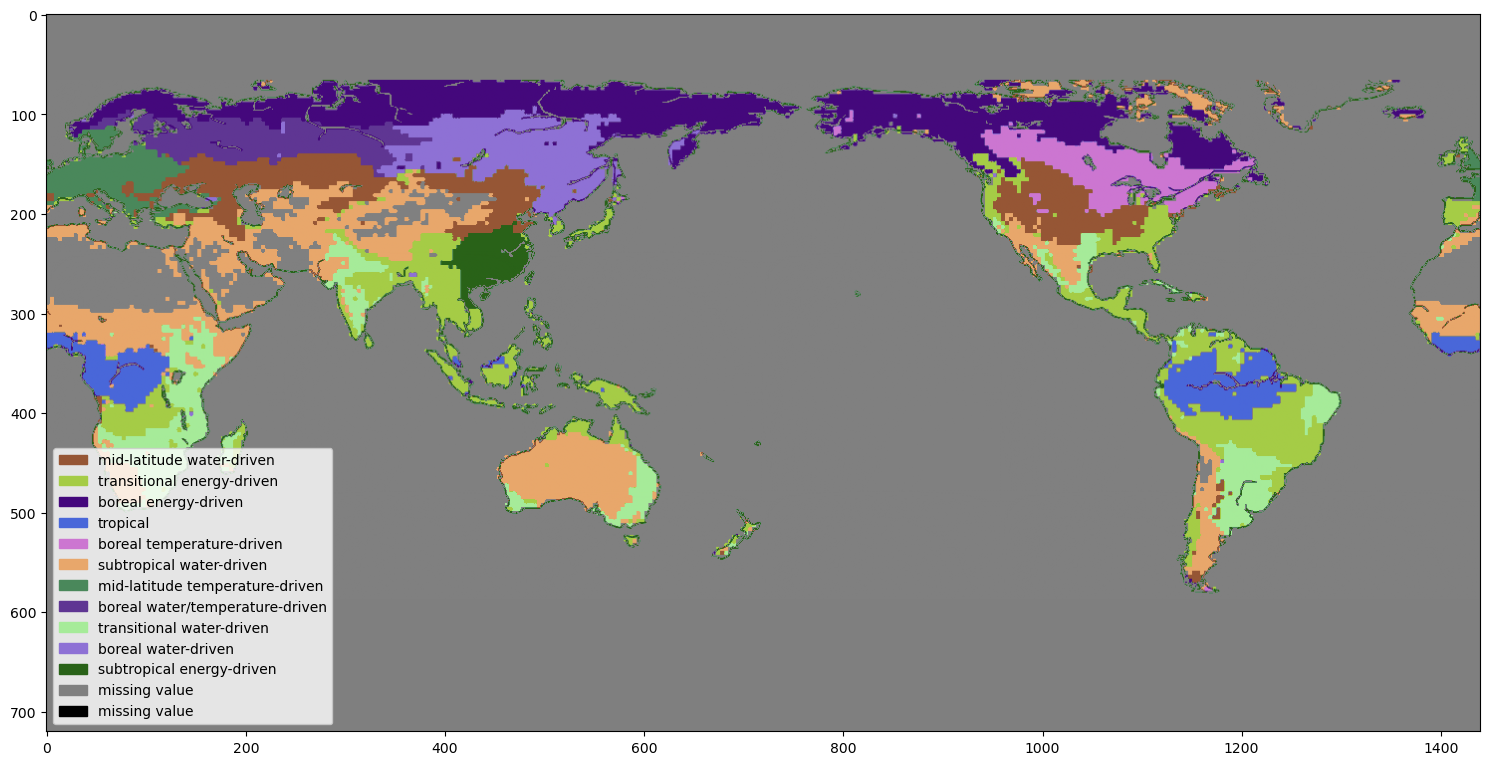

In [9]:

plot(reconstructed_data)

### Check if the positioning/scaling of the biome_map is correct compared to our own data

In [10]:
control_data = np.load("ndvi_timeseries_2011.npy")
mse_error = np.mean(np.abs(control_data[:, 0] - control_data[:, 1]), axis=0)

print(mse_error.shape)

(720, 1440)


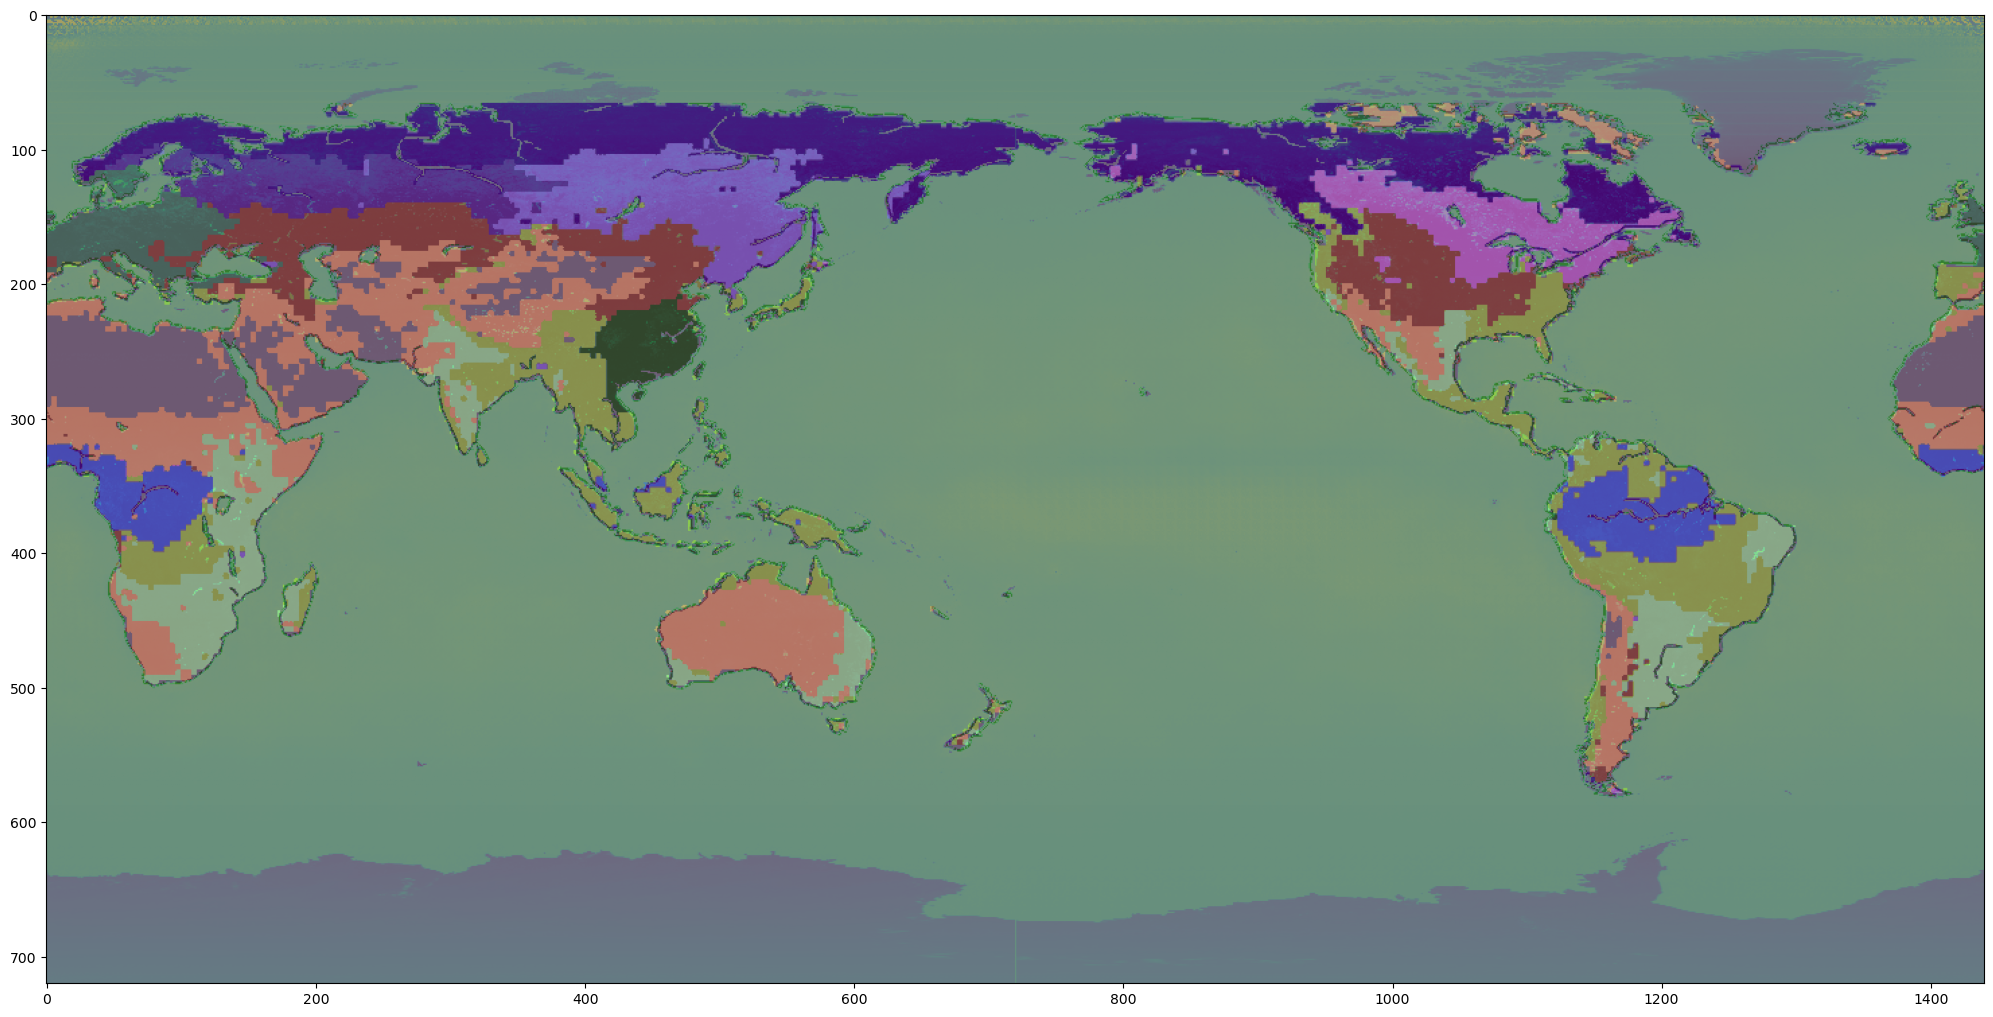

In [11]:

fig, ax = plt.subplots()
fig.set_size_inches(25, 15.5)

plt.imshow(mse_error)
plt.imshow(reconstructed_data, alpha=0.7)

plt.show()



### Save the biome map as a npy-file:

In [12]:
np.save("reconstructed_biomes.npy", reconstructed_biomes)